# Rt Live Model

Based on [Rt.live](https://Rt.live) model, original source code on [Github](https://github.com/rtcovidlive/covid-model).

Adapted for South Africa - Schalk van Heerden & Vukosi Marivate 5 July 2020

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

## Setup
Change paramter to **False** when running on your own local machine, but do not commit this change! Leave as **True** for Github Action `rtlive-model.yaml` to run remotely.

In [2]:
remote_run = False

## Troubleshooting

1. Ensure that all modules are installed with pip or conda from `requirments.txt`
1. How to solve Theano library warnings on some OS platform: [SO](https://stackoverflow.com/questions/53423610/how-to-update-scan-cython-code-in-theano)

# Baseline model with US data

While testing, run US model first to baseline the latest model files. For the latest stable model, checkout commit from 2 July 2020.

## Fetch data and select the state's data

In [25]:
df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [26]:
region = "OR"
model_data = df.loc[region]

In [27]:
model_data.tail()

,positive,total
date,,
2020-06-30,171.0,2501.0
2020-07-01,275.0,5726.0
2020-07-02,363.0,7694.0
2020-07-03,0.0,0.0
2020-07-04,636.0,3972.0


## Create the model instance and sample

In [28]:
gm = GenerativeModel(region, model_data)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
Sampling 4 chains, 0 divergences: 100%|██████████| 3600/3600 [08:48<00:00,  6.81draws/s]


## Summarize Model Output

In [29]:
result = summarize_inference_data(gm.inference_data)

100%|██████████| 800/800 [00:01<00:00, 410.40it/s]


In [30]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-06-25,1.240349,1.228184,1.032883,1.459470,167.958159,139.722801,134.562191,124.0,2610.0
2020-06-26,1.241703,1.233343,0.987535,1.436815,175.823793,144.866711,149.521593,174.0,3296.0
2020-06-27,1.240428,1.237826,1.025126,1.464637,184.190925,150.326135,149.521593,174.0,3296.0
2020-06-28,1.241278,1.236729,0.984269,1.450546,193.145163,156.131429,149.521593,174.0,3296.0
2020-06-29,1.241818,1.241941,1.007009,1.506778,202.684456,162.312583,22.988032,144.0,17742.0
2020-06-30,1.242657,1.235533,0.963229,1.465288,212.841169,168.897526,193.653027,171.0,2501.0
2020-07-01,1.245084,1.238681,1.003044,1.506901,223.702730,175.912447,136.026405,275.0,5726.0
2020-07-02,1.246009,1.239523,0.995680,1.522054,235.344164,183.380881,133.627645,363.0,7694.0
2020-07-03,1.250295,1.235307,0.984229,1.518722,247.860030,191.329253,0.000000,0.0,0.0


## Plot Model Output

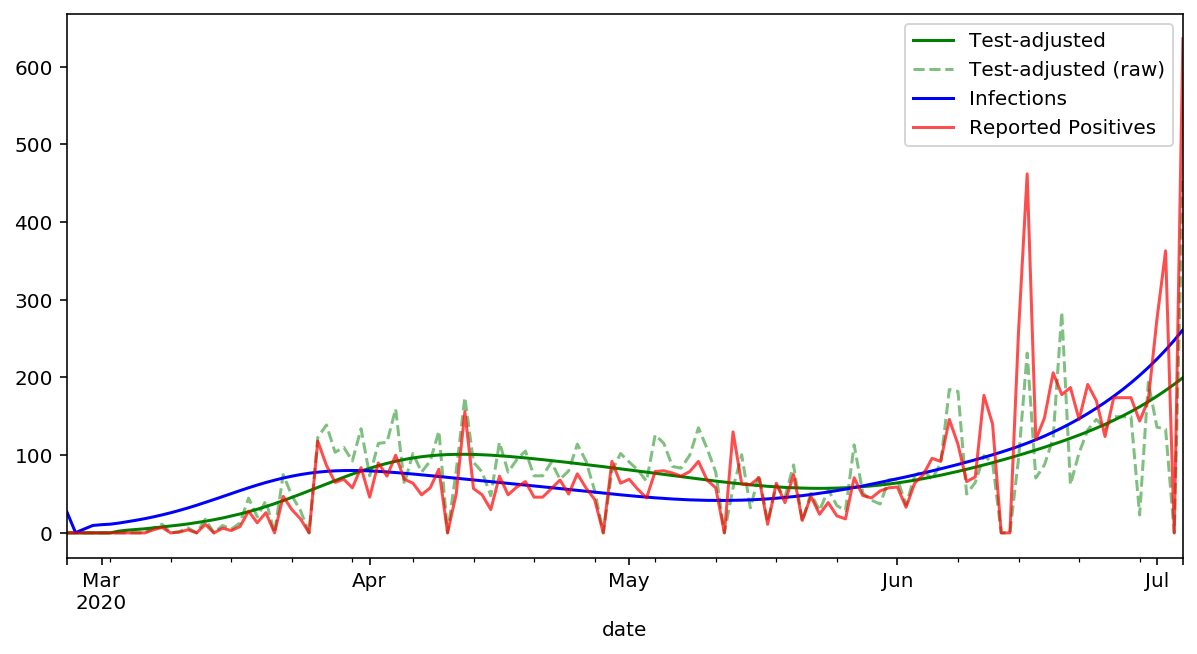

In [31]:
def plot_results():
    fig, ax = plt.subplots(figsize=(10,5))
    result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
    result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
    result.infections.plot(c="b", label="Infections")
    gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
    fig.set_facecolor('w')
    ax.legend();
    
plot_results()

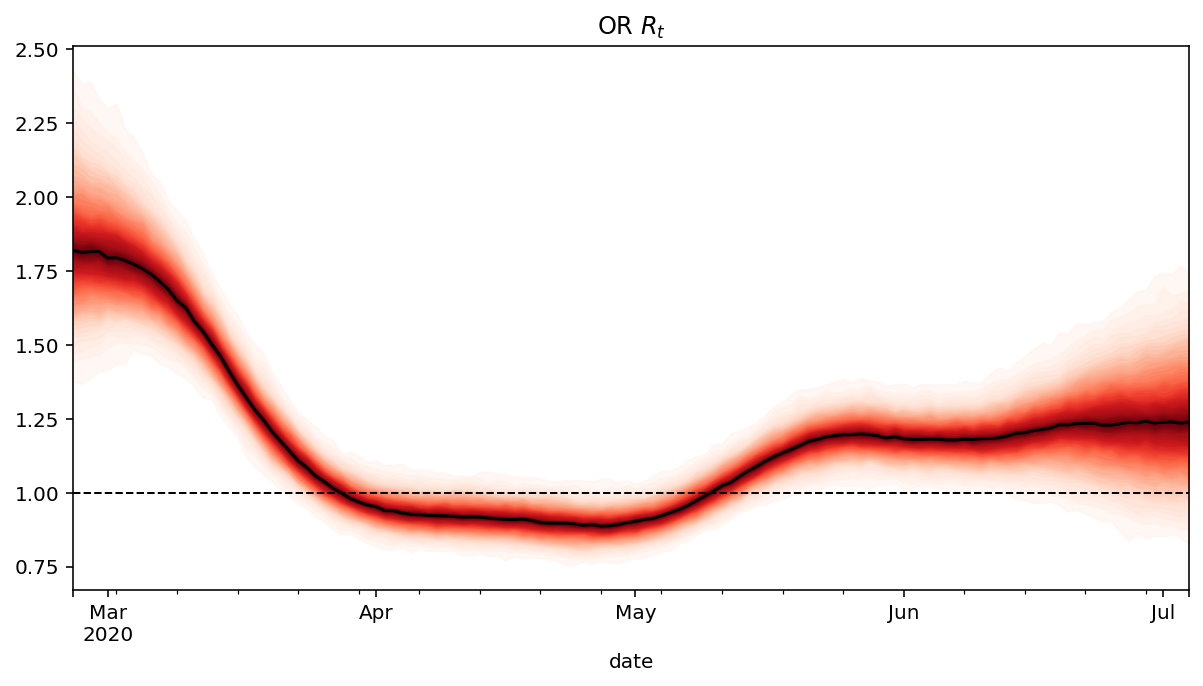

In [32]:
def plot_rt():
    fig, ax = plt.subplots(figsize=(10,5))

    ax.set_title(f"{region} $R_t$")
    samples = gm.trace['r_t']
    x=result.index
    cmap = plt.get_cmap("Reds")
    percs = np.linspace(51, 99, 40)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    samples = samples.T

    result["median"].plot(c="k", ls='-')

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(samples, p, axis=1)
        lower = np.percentile(samples, 100-p, axis=1)
        color_val = colors[i]
        ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

    ax.axhline(1.0, c="k", lw=1, linestyle="--")
    fig.set_facecolor('w')
    
plot_rt()

# South African Results

In [3]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_cases.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-07-01,20200701,29340.0,1672.0,45944.0,10632.0,1175.0,1306.0,494.0,4393.0,64377.0,0.0,159333,https://twitter.com/nicd_sa/status/12784055720...
2020-07-02,20200702,30603.0,1886.0,49937.0,11669.0,1286.0,1478.0,573.0,4788.0,65841.0,0.0,168061,https://twitter.com/DrZweliMkhize/status/12787...
2020-07-03,20200703,32157.0,2130.0,54331.0,12757.0,1408.0,1611.0,626.0,5168.0,66936.0,0.0,177124,https://twitter.com/nicd_sa/status/12791261637...
2020-07-04,20200704,34161.0,2376.0,59373.0,13984.0,1559.0,1818.0,686.0,5644.0,68376.0,0.0,187977,https://twitter.com/nicd_sa/status/12795389507...
2020-07-05,20200705,35648.0,2553.0,63404.0,15146.0,1706.0,1965.0,734.0,6063.0,69531.0,0.0,196750,https://twitter.com/nicd_sa/status/12798466117...


In [4]:
#url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_testing.csv'
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests.tail()

,YYYYMMDD,cumulative_tests,recovered,hospitalisation,critical_icu,ventilation,deaths,contacts_identified,contacts_traced,scanned_travellers,passengers_elevated_temperature,covid_suspected_criteria,source
date,,,,,,,,,,,,,
2020-06-30,20200630,1630008.0,73543,NaN,NaN,NaN,2657,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/06/30/update-...
2020-07-01,20200701,1666939.0,76025,NaN,NaN,NaN,2749,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/01/update-...
2020-07-02,20200702,1706127.0,81999,NaN,NaN,NaN,2844,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/02/update-...
2020-07-03,20200703,1745153.0,86298,NaN,NaN,NaN,2952,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/03/update-...
2020-07-04,20200704,1792078.0,91227,NaN,NaN,NaN,3026,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/04/update-...


In [5]:
cases = pd.Series(states_cases['total'], index=states_cases.index, name='cases')
cases

date
2020-03-05         1
2020-03-07         2
2020-03-08         3
2020-03-09         7
2020-03-11        13
               ...  
2020-07-01    159333
2020-07-02    168061
2020-07-03    177124
2020-07-04    187977
2020-07-05    196750
Name: cases, Length: 121, dtype: int64

In [6]:
casezero = states_cases.index[0]
caselast = states_cases.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-07-05 00:00:00'))

In [7]:
idx = pd.date_range(casezero, caselast)

In [8]:
tests_all = pd.Series(states_tests['cumulative_tests'], index=states_tests.index, name='tests')
tests_all

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-06-30    1630008.0
2020-07-01    1666939.0
2020-07-02    1706127.0
2020-07-03    1745153.0
2020-07-04    1792078.0
Name: tests, Length: 127, dtype: float64

In [9]:
tests = tests_all.loc[casezero:caselast]
tests

date
2020-03-06        200.0
2020-03-07        241.0
2020-03-11        645.0
2020-03-12        848.0
2020-03-13        924.0
                ...    
2020-06-30    1630008.0
2020-07-01    1666939.0
2020-07-02    1706127.0
2020-07-03    1745153.0
2020-07-04    1792078.0
Name: tests, Length: 118, dtype: float64

In [10]:
combined_model = pd.concat([cases, tests], axis=1)
combined_model

,cases,tests
date,,
2020-03-05,1.0,NaN
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-07-01,159333.0,1666939.0
2020-07-02,168061.0,1706127.0
2020-07-03,177124.0,1745153.0


In [11]:
# Assume previous day testing result for missing data point
combined_model.loc[casezero,'tests'] = 163

In [12]:
# Reindex complete date range
filled_model = combined_model.reindex(idx, method='ffill')
filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-07-01,159333.0,1666939.0
2020-07-02,168061.0,1706127.0
2020-07-03,177124.0,1745153.0
2020-07-04,187977.0,1792078.0


In [13]:
# Do a final clean up, assume previous day results for missing data points
final_filled_model = filled_model.ffill(axis=0)
final_filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,1.0,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,241.0
2020-03-09,7.0,241.0
...,...,...
2020-07-01,159333.0,1666939.0
2020-07-02,168061.0,1706127.0
2020-07-03,177124.0,1745153.0
2020-07-04,187977.0,1792078.0


In [14]:
final_filled_model['positive'] = final_filled_model['cases'].diff()
final_filled_model['total'] = final_filled_model['tests'].diff()
final_filled_model

,cases,tests,positive,total
2020-03-05,1.0,163.0,NaN,NaN
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
...,...,...,...,...
2020-07-01,159333.0,1666939.0,8124.0,36931.0
2020-07-02,168061.0,1706127.0,8728.0,39188.0
2020-07-03,177124.0,1745153.0,9063.0,39026.0
2020-07-04,187977.0,1792078.0,10853.0,46925.0


In [15]:
df_model = final_filled_model.iloc[1:-1]
df_model

,cases,tests,positive,total
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
2020-03-10,7.0,241.0,0.0,0.0
...,...,...,...,...
2020-06-30,151209.0,1630008.0,6945.0,33013.0
2020-07-01,159333.0,1666939.0,8124.0,36931.0
2020-07-02,168061.0,1706127.0,8728.0,39188.0
2020-07-03,177124.0,1745153.0,9063.0,39026.0


In [16]:
region = 'Total RSA'

In [17]:
gm = GenerativeModel(region, df_model)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
Sampling 4 chains, 0 divergences: 100%|██████████| 3600/3600 [08:22<00:00,  7.17draws/s]


In [18]:
result = summarize_inference_data(gm.inference_data)

100%|██████████| 800/800 [00:01<00:00, 424.23it/s]


In [19]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-06-25,1.211402,1.204174,0.982662,1.381239,4565.840096,4462.203954,3968.011456,6579.0,43118.0
2020-06-26,1.213153,1.199053,0.958374,1.373908,4752.492830,4623.828825,4884.158581,6215.0,33092.0
2020-06-27,1.214855,1.201311,0.995910,1.417836,4951.300082,4792.613534,5222.181630,7210.0,35905.0
2020-06-28,1.218847,1.202866,0.975167,1.420116,5162.857137,4969.085992,4326.231808,6334.0,38075.0
2020-06-29,1.218702,1.201066,0.991521,1.438188,5388.723344,5153.752679,5329.680570,6130.0,29911.0
2020-06-30,1.219871,1.200407,0.971484,1.409776,5631.305482,5347.120814,5470.901520,6945.0,33013.0
2020-07-01,1.219614,1.202876,0.956400,1.416337,5890.863118,5549.775871,5720.717294,8124.0,36931.0
2020-07-02,1.218514,1.195504,0.953167,1.419494,6167.150549,5762.509470,5792.063003,8728.0,39188.0
2020-07-03,1.218440,1.200908,0.933669,1.409656,6461.988000,5986.292182,6039.341375,9063.0,39026.0


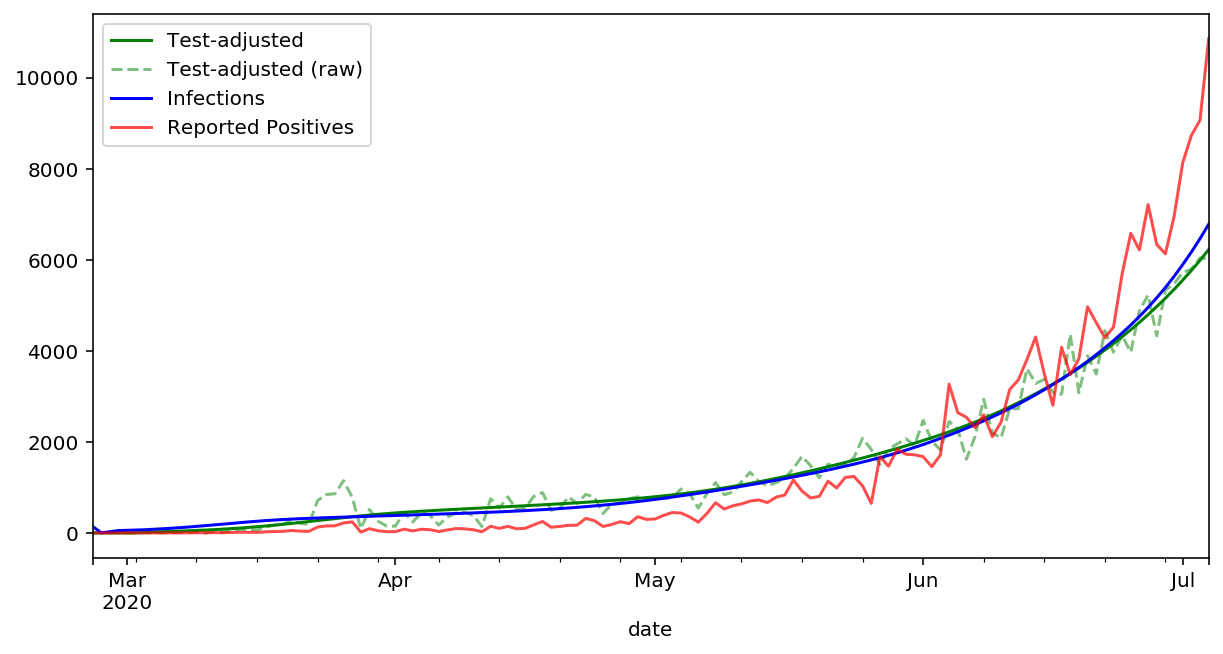

In [23]:
plot_results()

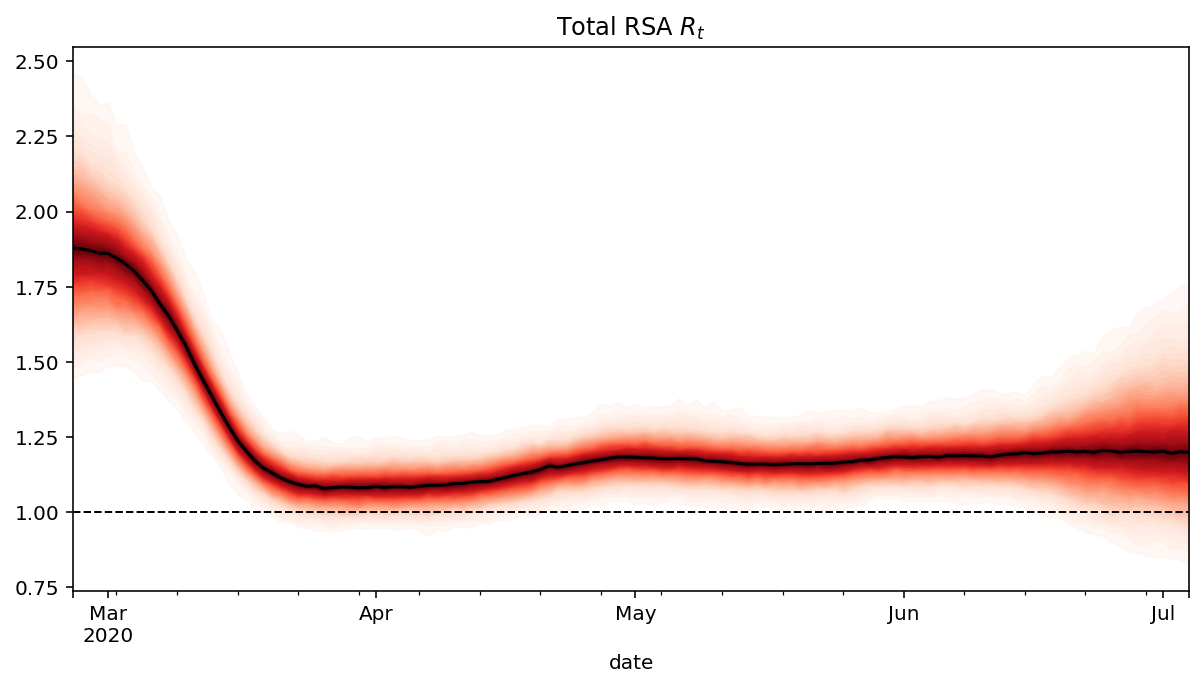

In [24]:
plot_rt()